In [4]:
pip install tensorflow numpy pandas matplotlib scikit-learn pillow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# prepare_dataset.py
import os
import shutil
import random

def subsample_dataset(source_dir, target_dir, num_images_per_class=150):
    """
    Creates a new directory with a random subsample of images from each class.
    """
    # Create the target directory, erasing it if it already exists
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)
    os.makedirs(target_dir)

    print(f"Creating subsampled dataset at: {target_dir}")

    # Get the list of class directories (e.g., '0', '1', '2', ...)
    class_dirs = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    for class_name in class_dirs:
        source_class_path = os.path.join(source_dir, class_name)
        target_class_path = os.path.join(target_dir, class_name)
        os.makedirs(target_class_path)

        # Get all image file names in the source class directory
        images = [f for f in os.listdir(source_class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Ensure we don't try to sample more images than available
        num_to_sample = min(num_images_per_class, len(images))

        # Randomly select the images
        selected_images = random.sample(images, num_to_sample)

        # Copy selected images to the new directory
        for image_name in selected_images:
            shutil.copy(os.path.join(source_class_path, image_name), target_class_path)
        
        print(f"Class '{class_name}': Copied {len(selected_images)} images.")

    print("\nSubsampling complete!")

# --- CONFIGURATION ---
# IMPORTANT: Update these paths to match your system
SOURCE_DATASET_PATH = "ITS Dataset" 
TARGET_DATASET_PATH = "ITS_Subsampled"
# ---------------------

if __name__ == '__main__':
    subsample_dataset(SOURCE_DATASET_PATH, TARGET_DATASET_PATH)

IMPORT

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
import shutil
import random


CONFIGURATION

In [6]:
# --- CONFIGURATION ---
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
EPOCHS = 15 # For the initial warm-up training

# Paths to the new split dataset
BASE_DATA_PATH = "split_dataset"
TRAIN_PATH = os.path.join(BASE_DATA_PATH, 'train')
VALIDATION_PATH = os.path.join(BASE_DATA_PATH, 'validation')
TEST_PATH = os.path.join(BASE_DATA_PATH, 'test')

DATA PREPARTION AND AUGMENTATION


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Setting up data generators with standard rescaling for MobileNetV2...")

# The training generator uses standard rescaling and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,          # REVERTED: Back to simple rescaling
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

# The validation generator ONLY rescales the images
validation_datagen = ImageDataGenerator(rescale=1./255) # REVERTED: Back to simple rescaling

# Create the generators from their respective directories
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = len(train_generator.class_indices)
print(f"\nSuccessfully found {NUM_CLASSES} classes.")

Setting up data generators with standard rescaling for MobileNetV2...
Found 9743 images belonging to 58 classes.
Found 2088 images belonging to 58 classes.

Successfully found 58 classes.


BUILD THE MODEL

In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import tensorflow as tf

print("\nBuilding the model using MobileNetV2...")

# Load the MobileNetV2 base model, pre-trained on ImageNet
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the layers of the base model for initial training
base_model.trainable = False

# Add our custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x) # Reverted to 128 units, suitable for MobileNetV2
x = Dropout(0.5)(x) 
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Construct the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with the safer initial learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print a summary of the model architecture
model.summary()


Building the model using MobileNetV2...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,429,434 (9.27 MB)

 Trainable params: 171,450 (669.73 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

CALCULATE THE WEIGHTS

In [9]:
from sklearn.utils import class_weight
import numpy as np

print("Calculating class weights to handle imbalances...")

# Get the class labels for all training samples
class_labels = train_generator.classes

# Calculate class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

# Create a dictionary mapping the class index to its calculated weight
class_weights = dict(zip(np.unique(class_labels), weights))

print("\nClass Weights Calculated. The model will now pay more attention to under-represented or difficult classes.")

Calculating class weights to handle imbalances...

Class Weights Calculated. The model will now pay more attention to under-represented or difficult classes.


INITIAL TRAINING OF THE MODEL

In [10]:
print("\nStarting initial warm-up training...")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weights # ADDED: Apply class weights
)

# Save the trained model
model.save("indian_traffic_sign_weights.h5")
print("\nBaseline model saved as 'indian_traffic_sign_baseline.h5'")


Starting initial warm-up training...


c:\Users\Vinay Venkatachalam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 83s 256ms/step - accuracy: 0.2053 - loss: 3.3696 - val_accuracy: 0.6293 - val_loss: 1.4385
Epoch 2/15
  1/304 ━━━━━━━━━━━━━━━━━━━━ 30s 100ms/step - accuracy: 0.5312 - loss: 2.0561

c:\Users\Vinay Venkatachalam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


304/304 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5312 - loss: 2.0561 - val_accuracy: 0.6303 - val_loss: 1.4363
Epoch 3/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 85s 280ms/step - accuracy: 0.5348 - loss: 1.6571 - val_accuracy: 0.6894 - val_loss: 1.0731
Epoch 4/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6250 - loss: 1.1201 - val_accuracy: 0.6870 - val_loss: 1.0735
Epoch 5/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 83s 272ms/step - accuracy: 0.6181 - loss: 1.2957 - val_accuracy: 0.7101 - val_loss: 0.8758
Epoch 6/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.6562 - loss: 1.9966 - val_accuracy: 0.7154 - val_loss: 0.8773
Epoch 7/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 77s 253ms/step - accuracy: 0.6685 - loss: 1.0852 - val_accuracy: 0.7375 - val_loss: 0.8003
Epoch 8/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.7188 - loss: 0.8074 - val_accuracy: 0.7365 - val_loss: 0.7994
Epoch 9/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 82s 269ms/step - accuracy: 0.7023 - loss: 0.9645 - val_accurac


Baseline model saved as 'indian_traffic_sign_baseline.h5'


FINE TUNING THE MODEL

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

print("\n--- Starting Controlled Fine-Tuning for MobileNetV2 ---")

# --- 1. Set up Cautious Unfreezing ---
base_model.trainable = True
fine_tune_at = 140 

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# --- 2. Re-compile with Adam and a low learning rate ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Using Adam as requested
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel re-compiled for fine-tuning.")
model.summary()

# --- 3. Define Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7, verbose=1)

# --- 4. Continue Training ---
fine_tune_epochs = 25
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weights # ADDED: Apply class weights
)

# --- 5. Save the final fine-tuned model ---
model.save("indian_traffic_sign_finetuned.h5")
print("\nFine-tuned model saved as 'indian_traffic_sign_finetuned.h5'")


--- Starting Controlled Fine-Tuning for MobileNetV2 ---

Model re-compiled for fine-tuning.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,429,434 (9.27 MB)

 Trainable params: 1,211,450 (4.62 MB)

 Non-trainable params: 1,217,984 (4.65 MB)

Epoch 15/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 97s 272ms/step - accuracy: 0.5201 - loss: 1.8906 - val_accuracy: 0.7668 - val_loss: 0.6808 - learning_rate: 1.0000e-05
Epoch 16/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6250 - loss: 1.4887 - val_accuracy: 0.7673 - val_loss: 0.6808 - learning_rate: 1.0000e-05
Epoch 17/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 86s 281ms/step - accuracy: 0.6438 - loss: 1.1675 - val_accuracy: 0.7683 - val_loss: 0.6680 - learning_rate: 1.0000e-05
Epoch 18/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.6875 - loss: 1.3256 - val_accuracy: 0.7678 - val_loss: 0.6678 - learning_rate: 1.0000e-05
Epoch 19/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 83s 272ms/step - accuracy: 0.6745 - loss: 1.0217 - val_accuracy: 0.7740 - val_loss: 0.6395 - learning_rate: 1.0000e-05
Epoch 20/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7500 - loss: 0.9687 - val_accuracy: 0.7740 - val_loss: 0.6392 - learning_rate: 1.0000e-05
Epoch 21/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 92s 3


Fine-tuned model saved as 'indian_traffic_sign_finetuned.h5'


PLOT THE TRAINING HISTORY

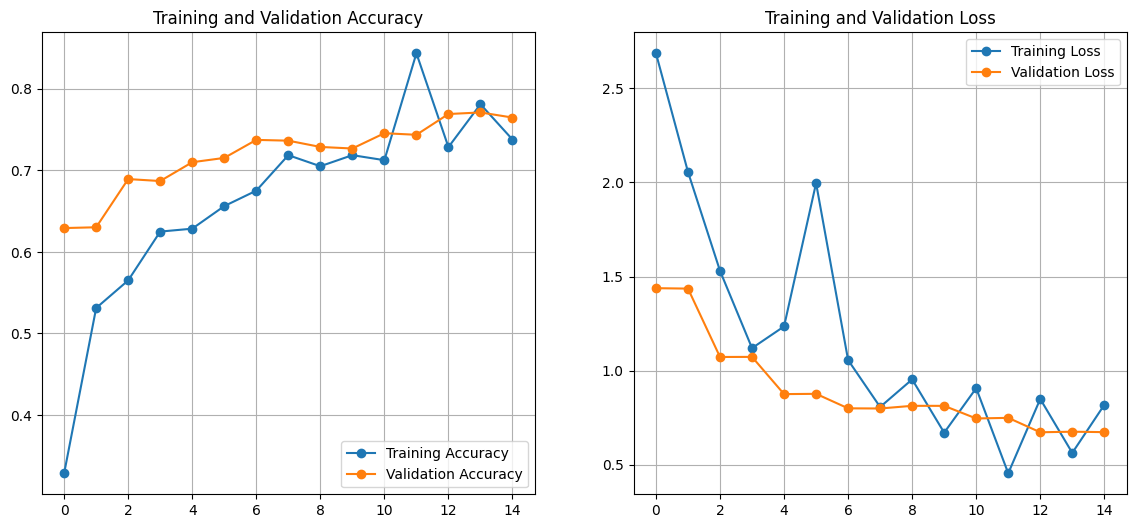

In [12]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid(True)
    
    plt.show()

plot_history(history)

PERFORMANCE MEASURE

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

print("Evaluating model performance on the validation set...")

# Get the true labels from the validation generator
y_true = validation_generator.classes

# Predict the classes for the validation set
validation_generator.reset()
Y_pred = model.predict(validation_generator, steps=int(np.ceil(validation_generator.samples / BATCH_SIZE)))
y_pred = np.argmax(Y_pred, axis=1)

# --- METRIC CALCULATIONS ---

# 1. Overall Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"## Overall Accuracy: {accuracy:.4f}\n")

# 2. Precision, Recall (Sensitivity), F1-Score
# This report provides the main metrics per class and their averages.
print("## Classification Report (Precision, Recall/Sensitivity, F1-Score):")
class_names = list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))

# 3. Specificity
# Specificity needs to be calculated on a per-class basis (one-vs-rest).
# Specificity = True Negatives / (True Negatives + False Positives)
cm = confusion_matrix(y_true, y_pred)
total_samples = np.sum(cm)
specificities = []

for i in range(NUM_CLASSES):
    # For class i
    tp = cm[i, i]
    fp = np.sum(cm[:, i]) - tp
    fn = np.sum(cm[i, :]) - tp
    tn = total_samples - (tp + fp + fn)
    
    # Calculate specificity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    specificities.append(specificity)

# Calculate the average specificity across all classes
avg_specificity = np.mean(specificities)
print("------------------------------------------------------")
print(f"## Average Specificity: {avg_specificity:.4f}")
print("------------------------------------------------------")

Evaluating model performance on the validation set...
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step
## Overall Accuracy: 0.8118

## Classification Report (Precision, Recall/Sensitivity, F1-Score):
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        30
           1       0.81      0.97      0.88        30
          10       0.96      0.90      0.93        30
          11       0.94      1.00      0.97        30
          12       0.88      1.00      0.94        30
          13       1.00      0.87      0.93        30
          14       0.96      0.90      0.93        30
          15       0.81      0.73      0.77        30
          16       0.67      0.67      0.67        30
          17       0.77      0.90      0.83        30
          18       0.88      0.93      0.90        30
          19       0.89      0.83      0.86        30
           2       0.60      0.30      0.40        30
          20       0.93      0.73      0.82        

FINAL EVALUATION ON TEST DATA

In [14]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Final Evaluation on the Unseen Test Set ---")

# 1. Load the best saved model
# Make sure the filename matches the one you saved in the fine-tuning step
final_model = load_model("indian_traffic_sign_finetuned.h5")

# 2. Create a data generator for the test set
# IMPORTANT: No augmentation, just rescaling. Shuffle must be False.
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 3. Evaluate the model to get loss and accuracy
print("\nCalculating Test Loss and Accuracy...")
test_loss, test_accuracy = final_model.evaluate(test_generator)
print(f"## Test Accuracy: {test_accuracy:.4f}")
print(f"## Test Loss: {test_loss:.4f}")

# 4. Generate a detailed classification report
print("\n--- Test Classification Report ---")

# Get true labels
y_true = test_generator.classes

# Predict probabilities
Y_pred_probs = final_model.predict(test_generator, steps=int(np.ceil(test_generator.samples / BATCH_SIZE)))
# Convert probabilities to class labels
y_pred = np.argmax(Y_pred_probs, axis=1)

# Get class names
class_names = list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))

# 5. Calculate Average Specificity for the test set
cm = confusion_matrix(y_true, y_pred)
total_samples = np.sum(cm)
specificities = []

for i in range(NUM_CLASSES):
    tp = cm[i, i]
    fp = np.sum(cm[:, i]) - tp
    fn = np.sum(cm[i, :]) - tp
    tn = total_samples - (tp + fp + fn)
    
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    specificities.append(specificity)

avg_specificity = np.mean(specificities)
print("------------------------------------------------------")
print(f"## Average Test Specificity: {avg_specificity:.4f}")
print("------------------------------------------------------")

--- Final Evaluation on the Unseen Test Set ---


Found 2140 images belonging to 58 classes.


c:\Users\Vinay Venkatachalam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Calculating Test Loss and Accuracy...
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.7853 - loss: 0.6087
## Test Accuracy: 0.7967
## Test Loss: 0.5450

--- Test Classification Report ---
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step
              precision    recall  f1-score   support

           0       0.82      0.87      0.84        31
           1       0.89      0.77      0.83        31
          10       1.00      0.87      0.93        31
          11       0.88      0.97      0.92        31
          12       0.97      0.97      0.97        31
          13       1.00      0.90      0.95        31
          14       0.94      0.94      0.94        31
          15       0.83      0.81      0.82        31
          16       0.65      0.71      0.68        31
          17       0.63      0.87      0.73        31
          18       0.90      0.90      0.90        31
          19       0.93      0.90      0.92        31
           2       0.50      0.16      0.24        31
       